In [13]:
# Print text to text file.
def print_to_txt(file_content, project_name, content_description, save_to_project_dir = False):
    import os
    from tabulate import tabulate
    output_file_name = project_name + '_' + content_description + '.txt'
    if save_to_project_dir == False:
        with open(output_file_name, "w") as text_file:
            print(tabulate(file_content, tablefmt="pipe"), file=text_file)
    else: 
        os.chdir(project_name)
        with open(output_file_name, "w") as text_file:
            print(file_content, file=text_file)
        os.chdir('..')

# Shorten input string to n characters and ellipsis '...'.
def shorten_string(string, n):
    if len(string) < n: return string
    else: return string[0:n] + '...'

# Add line breaks to long string.
## In: String x and number of characters to add line breaks at.
## Out: String y with a line break every max_chars of x.
def add_line_breaks(x, max_chars):
    import math
    y = str()
    cc = 0
    for i in x.split(): 
        cc = cc + len(i)
        y = y + ' ' + i
        if cc > max_chars:
            cc = 0
            y = y + '\n'
    return y

# Setup project name and directory.
## Project name is a global variable, and will prefix all output files.
## Project name directory is created within current directory.
def setup_project(name, create_subdirectory = False):
    if create_subdirectory == True: 
        import os
        os.mkdir(os.path.expanduser(name))
    global project_name
    project_name = name

# Raw Data from CSV
## In: CSV file, with any number of columns, first row must have column names.
## Out: Two dicts, one keyed Attributes, has a list of column names; the other keyed Content has integer keys, each entry is itself a dict of row values, keyed by column names.
def raw_data_from_CSV(csv_file, delimiter_character):
    raw_data = {}
    import csv
    with open(csv_file) as file:
        data = csv.reader(file, delimiter = delimiter_character)
        j = 0
        for i in data: 
            if j == 0: 
                attribute_names = i
            if j > 0:
                raw_data[j-1] = dict()
                for k in range(0,len(attribute_names)):
                    raw_data[j-1][attribute_names[k]] = i[k]
            j = j + 1
    return { 'Attributes': attribute_names, 'Content': raw_data }

# Structure raw data.
## In: raw, which is the output of raw_data_from_CSV.
## Out: Dict, where each item is one item from raw, with a series of properties describing that item. 
## Note: In Out, properties are selected so as to preserve the information in the structure of raw. 
## For example, if two items were in the same key in raw (same row in the original CSV), 
## then there must be a relationship over them, in Out.
def structure_raw_data(raw):
    o = dict()
    r = dict()
    id_c = 1
    ats = raw['Attributes']
    for c in raw['Content']:
        for a1 in ats:
            # Unary properties.
            item_id = 'n_' + str(id_c)
            id_c = id_c + 1
            full_name = raw['Content'][c][a1]
            
            # Relationships that d['Content'][c][a1] is involved in.
            d_c_a1 = dict()
            r[raw['Content'][c][a1]] = d_c_a1
            
            for a2 in ats:
                if a1 != a2: d_c_a1[a1,a2] = (full_name, raw['Content'][c][a2])
            
            # Add entry for d['Content'][c][a1] to o.
            o[item_id] = { 'uid': item_id, 
                          'nickname': shorten_string(full_name, 15), 
                          'full_name': full_name, 
                          'instance_of': a1, 
                          'relationships':  d_c_a1 }
    return o

# Make a multi digraph that only has all edges of one relationship type.
## In: d is output of structure_raw_data, rel_from is the name of the type of origin node, and rel_to is the type of destination node.
def make_rel_net(d, rel_from, rel_to):
    global nx
    import networkx as nx
    rel_net = nx.MultiDiGraph()
    for i in d:
        for j in d[i]['relationships']:
            if j == (rel_from, rel_to): 
                rel_net.add_edge(d[i]['relationships'][j][0], d[i]['relationships'][j][1])
    return rel_net

# Position nodes, with x value function of in_degrees of each node.
# In: Graph whose nodes need positions.
# Out: 
def pos_by_in_degrees(graph):
    import math
    pos_out = dict()
    y = 1
    s = 1 + max(dict(graph.in_degree()).values())
    for e in graph.edges():
        pos_out[e[0]] = [graph.in_degree()[e[0]], y]
        pos_out[e[1]] = [graph.in_degree()[e[1]], y]
        y = y + 10 * s
    return pos_out

# Format node labels.
# Label nodes with full_name, newline every 30 characters, shorten after first 87 characters.
def format_node_labels(graph, sd, original_attribute, line_length, total_length):
    fl = dict()
    for i in sd:
        for n in graph.nodes():
            if n == sd[i][original_attribute]:
                fl[sd[i][original_attribute]] = shorten_string(add_line_breaks(sd[i][original_attribute], line_length), total_length)
    return fl

# Offset positions of node labels, relative to node positions.
# In: Node positions, offset_x and offset_y to add to x and y of each node's position.
# Out: Offset positions dict.
def offset_node_labels(node_pos, offset_x, offset_y):
    offset_pos = dict()
    for i in node_pos:
        offset_pos[i] = [node_pos[i][0] + offset_x, node_pos[i][1] + offset_y]
    return offset_pos

# Make a list of randomly made HTML color codes.
# Returns list with as many random colors as number_of_colors.
def make_color_list(number_of_colors):
    import random
    color_list = list()
    color_list = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]
    return color_list

# Color nodes with random colors, roots are of same color (#DDDDDD by default).
def color_nodes(graph, color_list, root_color = '#DDDDDD'):
    node_colors = dict()
    c = 0
    for n in graph.nodes():
        if graph.in_degree()[n] == 0: 
            node_colors[n] = root_color
        else:
            node_colors[n] = color_list[c]
            c = c + 1
    return node_colors

# Color edge with target node color.
def color_edge_by_target_node(graph, node_colors_dict):
    edge_colors = list()
    for o, d in graph.edges():
        edge_colors.append(node_colors_dict[d])
    return edge_colors

# Draw a Relationship Network.
def draw_rel_net(graph, node_positions, node_labels, node_label_positions, node_colors, edge_labels, edge_colors, fig_w = 10, fig_h = 10, dpi_val = 90, fig_margin = 0.15):
    import networkx as nx
    import matplotlib
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    plt.figure(num=None, figsize=(fig_w, fig_h), dpi=dpi_val, facecolor='w')
    plt.margins(fig_margin)
    plt.axis('off')
    nx.draw_networkx_nodes(graph, node_positions, node_color = list(node_colors.values()), node_shape = 'o', node_size = 20)
    nx.draw_networkx_labels(graph, pos = node_label_positions, labels = node_labels, font_size = 8)
    nx.draw_networkx_edges(graph, node_positions, edge_color = edge_colors)
    nx.draw_networkx_edge_labels(graph, node_positions, edge_labels = edge_labels, font_size = 8)
    return


In [5]:
# import ilang_fs as il

In [14]:
setup_project('SRN', True)

FileExistsError: [Errno 17] File exists: 'SRN'

In [15]:
d = raw_data_from_CSV('raw_data/ilang_SRN_data.csv', ',')

In [16]:
d

{'Attributes': ['Definiendum', 'Short Definiendum', 'Definiens'],
 'Content': {0: {'Definiendum': 'SRN',
   'Short Definiendum': 'SRN',
   'Definiens': 'Smart Retail Network software.'},
  1: {'Definiendum': 'SDM',
   'Short Definiendum': 'SDM',
   'Definiens': 'Shop Display Management software.'},
  2: {'Definiendum': 'Shop Display',
   'Short Definiendum': 'Shop Display',
   'Definiens': 'Object installed at a POP, which is used to promote products; Shop Display is synonym with Fixture.'},
  3: {'Definiendum': 'Basic Shop Display',
   'Short Definiendum': 'BSD',
   'Definiens': 'A Shop Display which cannot itself be subdivided.'},
  4: {'Definiendum': 'Complex Shop Display',
   'Short Definiendum': 'CSD',
   'Definiens': 'A Shop Display made from two or more Basic Shop Displays.'},
  5: {'Definiendum': 'Shop Display Identifier',
   'Short Definiendum': 'SDID',
   'Definiens': 'Unique numeric identifier generated by SDM for each BSD, used to identify a BSD when a QR code scanner is no

In [17]:
import os
print(os.getcwd())

/Users/ivanjureta/Documents/GitHub/ilang/analysis


In [18]:
project_name = 'SRN'

In [19]:
print_to_txt(d, project_name, 'raw_data', True)

In [20]:
import os
print(os.getcwd())

/Users/ivanjureta/Documents/GitHub/ilang/analysis


In [1]:
project_name = 'SRN'

In [9]:
print_to_txt(d, project_name, 'raw_data', True)

In [2]:
d

NameError: name 'd' is not defined

In [47]:
d = il.raw_data_from_CSV('raw_data/ilang_SRN_data.csv', ',') 

In [48]:
sd = il.structure_raw_data(d)

In [49]:
td = il.make_rel_net(sd, 'Definiens', 'Definiendum')

In [50]:
n_p = il.pos_by_in_degrees(td)

In [51]:
n_labels = il.format_node_labels(td, sd, 'full_name', 30, 55)

In [52]:
pos_node_labels = il.offset_node_labels(n_p, 0, 1)

In [53]:
colors = il.make_color_list(len(td.nodes()))

In [54]:
colored_nodes = il.color_nodes(td, colors, '#FFFFFF')

In [55]:
color_edges = il.color_edge_by_target_node(td, colored_nodes)

In [56]:
# define label on all edges
edgelabels = dict()
for e in td.edges(): edgelabels[e] = 'defines'

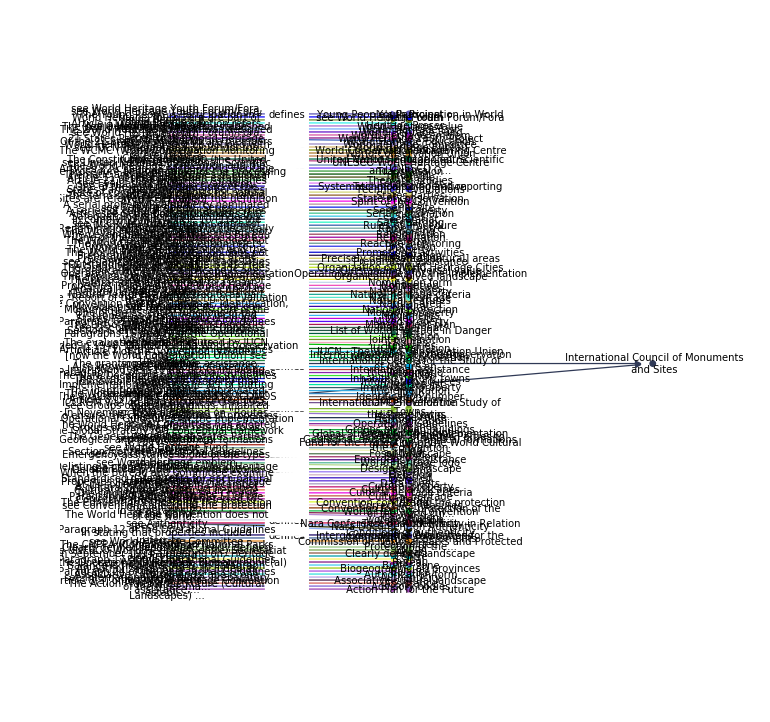

In [57]:
fg = draw_rel_net(graph = td, node_positions = n_p, node_labels = n_labels, node_colors = colored_nodes, edge_labels = edgelabels, edge_colors = color_edges)

In [ ]:
def draw_rel_net(graph, node_positions, node_labels, node_colors, edge_labels, edge_colors, fig_w = 10, fig_h = 10, dpi_val = 90, fig_margin = 0.15):
    import networkx as nx
    import matplotlib
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    plt.figure(num=None, figsize=(fig_w, fig_h), dpi=dpi_val, facecolor='w')
    plt.margins(fig_margin)
    plt.axis('off')
    nx.draw_networkx_nodes(graph, node_positions, node_color = list(node_colors.values()), node_shape = 'o', node_size = 20)
    nx.draw_networkx_labels(graph, pos = pos_node_labels, labels = node_labels, font_size = 8)
    nx.draw_networkx_edges(graph, node_positions, edge_color = edge_colors)
    nx.draw_networkx_edge_labels(graph, node_positions, edge_labels = edge_labels, font_size = 8)
    return


In [63]:
import os
retval = os.getcwd()
print("Current working directory %s" % retval)

Current working directory /Users/ivanjureta/Documents/GitHub/ilang/analysis


In [64]:
os.chdir(eval('/' + project_name))

NameError: name 'project_name' is not defined

In [66]:
il.setup_project('SRN', create_subdirectory = True)

In [76]:
retval = os.getcwd()

In [77]:
print(retval)

/Users/ivanjureta/Documents/GitHub/ilang/analysis/SRN


In [75]:
os.chdir(project_name)

In [70]:
project_name

NameError: name 'project_name' is not defined

In [73]:
project_name = 'SRN'

In [81]:
retval

'/Users/ivanjureta/Documents/GitHub/ilang/analysis/SRN'

In [82]:
os.chdir('..')

In [83]:
print(os.getcwd())

/Users/ivanjureta/Documents/GitHub/ilang/analysis
